## Importación de las librerías

In [49]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import PowerTransformer, LabelEncoder, MinMaxScaler
from sklearn.impute import KNNImputer

import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="whitegrid")

## Importación del dataset

In [50]:
stroke_df = pd.read_csv('/kaggle/input/exploratory-data-analysis/stroke_df_with_outliers_missings.csv')
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## División train-test

A continuación se procede a dividir el dataset importado en los conjuntos de **train** y **test**. Debido a que estamos tratando un problema de clasificación bastante desbalanceado, utilizaremos el ***stratifiedshufflesplit*** para conservar las proporciones de cada clase en los distintos conjuntos mencionados anteriormente.  

In [51]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=99)
X_train, X_test, y_train, y_test = None, None, None, None

for train_index, test_index in sss.split(stroke_df.drop(columns=['stroke']), stroke_df['stroke']):
    train_df = stroke_df.iloc[train_index]
    test_df = stroke_df.iloc[test_index]
    X_train, y_train = train_df.drop(columns=['stroke']), train_df.stroke
    X_test, y_test = test_df.drop(columns=['stroke']), test_df.stroke

Hacemos una comprobación de que las proporciones se han mantenido

In [52]:
print("TRAIN:\n", y_train.value_counts(normalize=True))
print('-'*50)
print("TEST:\n", y_test.value_counts(normalize=True))

TRAIN:
 0    0.951309
1    0.048691
Name: stroke, dtype: float64
--------------------------------------------------
TEST:
 0    0.951076
1    0.048924
Name: stroke, dtype: float64


## Tratamiento de los outliers

In [53]:
def detect_outliers_iqr(data, factor=3):
    # finding the 1st quartile
    q1 = np.nanquantile(data, 0.25)
 
    # finding the 3rd quartile
    q3 = np.nanquantile(data, 0.75)
 
    # finding the iqr region
    iqr = q3-q1
        
    # finding upper and lower whiskers
    upper_bound = q3+(factor*iqr)
    lower_bound = q1-(factor*iqr)
                    
    return len(data[(data<lower_bound) | (data>upper_bound)])

Las variables que presentan outliers son **BMI** y **avg_glucose_level**

In [54]:
print("\nPosible Outliers IQR age:", detect_outliers_iqr(stroke_df.age))
print("\nPosible Outliers IQR bmi:", detect_outliers_iqr(stroke_df.bmi))
print("\nPosible Outliers IQR avg_glucose_level:", detect_outliers_iqr(stroke_df.avg_glucose_level))


Posible Outliers IQR age: 0

Posible Outliers IQR bmi: 8

Posible Outliers IQR avg_glucose_level: 165


Se realiza el tratamiento de los outliers de la misma forma que el notebook anterior, con las **transformaciones box-cox**

### Variable avg_glucose_level

In [55]:
power_transformer = PowerTransformer(method='box-cox')
avg_glucose_level_transformed = power_transformer.fit_transform(X_train[['avg_glucose_level']])
X_train['avg_glucose_level'] = avg_glucose_level_transformed.flatten()
X_test['avg_glucose_level'] = power_transformer.transform(X_test[['avg_glucose_level']])

In [56]:
print("\nPosible Outliers train avg_glucose_level:", detect_outliers_iqr(X_train.avg_glucose_level))
print("\nPosible Outliers test avg_glucose_level:", detect_outliers_iqr(X_test.avg_glucose_level))


Posible Outliers train avg_glucose_level: 0

Posible Outliers test avg_glucose_level: 0


### Variable BMI

In [57]:
power_transformer = PowerTransformer(method='box-cox')
bmi_transformed = power_transformer.fit_transform(X_train[['bmi']])
X_train['bmi'] = bmi_transformed.flatten()
X_test['bmi'] = power_transformer.transform(X_test[['bmi']])

In [58]:
print("\nPosible Outliers train bmi:", detect_outliers_iqr(X_train.bmi))
print("\nPosible Outliers test bmi:", detect_outliers_iqr(X_test.bmi))


Posible Outliers train bmi: 1

Posible Outliers test bmi: 0


## Tratamiento de los valores perdidos

Debido a que para la imputación de los valores perdidos se utilizará el algoritmo **KNN** que depende de la distancia euclidea entre las muestras, en primer lugar se crea el dataframe con las variables que se tendrán en cuenta en la imputación citada.

In [59]:
X_train_imputation = X_train[['hypertension', 'ever_married', 'work_type', 'smoking_status', 'age', 'bmi']]
X_test_imputation = X_test[['hypertension', 'ever_married', 'work_type', 'smoking_status', 'age', 'bmi']]
X_train_imputation.head()

,hypertension,ever_married,work_type,smoking_status,age,bmi
3503,1,Yes,Govt_job,formerly smoked,54.0,0.559616
297,1,Yes,Govt_job,smokes,58.0,-0.144154
2200,0,Yes,Self-employed,smokes,31.0,1.488907
1019,0,Yes,Self-employed,never smoked,66.0,0.061609
988,0,No,Private,Unknown,20.0,-0.005701


Se juntan las categorías en la variable **work_type** y **smoking_type** debido a lo mencionado en el notebook anterior (eran categorías que no presentaban diferencias significativas en la variable BMI)

In [60]:
X_train_imputation.work_type.replace({'Govt_job': 'other', 'Self-employed': 'other', 'Private': 'other'}, inplace=True)
X_train_imputation.smoking_status.replace({'formerly smoked': 'other', 'smokes': 'other', 'never smoked': 'other'}, inplace=True)

X_test_imputation.work_type.replace({'Govt_job': 'other', 'Self-employed': 'other', 'Private': 'other'}, inplace=True)
X_test_imputation.smoking_status.replace({'formerly smoked': 'other', 'smokes': 'other', 'never smoked': 'other'}, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [61]:
print(X_train_imputation.work_type.value_counts())
print('-'*50)
print(X_train_imputation.smoking_status.value_counts())
print('-'*50)
print(X_test_imputation.work_type.value_counts())
print('-'*50)
print(X_test_imputation.smoking_status.value_counts())

other       3510
children     577
Name: work_type, dtype: int64
--------------------------------------------------
other      2835
Unknown    1252
Name: smoking_status, dtype: int64
--------------------------------------------------
other       890
children    132
Name: work_type, dtype: int64
--------------------------------------------------
other      730
Unknown    292
Name: smoking_status, dtype: int64


Se codifican las variables categóricas (en este caso todas son binarias) con 0 y 1 con el LabelEncoder()

In [62]:
categorical_vars = ['hypertension', 'ever_married', 'work_type', 'smoking_status']
label_encoder = LabelEncoder()

for var in categorical_vars:
    X_train_imputation[var] = label_encoder.fit_transform(X_train_imputation[var])
    X_test_imputation[var] = label_encoder.transform(X_test_imputation[var])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Otro punto crítico aquí es que el Imputador **KNN** es un método de imputación basado en la distancia y requiere que normalicemos nuestros datos. De lo contrario, las diferentes escalas de nuestros datos llevarán al Imputador KNN a generar reemplazos sesgados para los valores perdidos. Para simplificar, utilizaremos el **MinMaxScaler** de Scikit-Learn que escalará nuestras variables para que tengan valores entre 0 y 1.

In [63]:
min_max_scaler = MinMaxScaler()
X_train_imputation[['age', 'bmi']] = min_max_scaler.fit_transform(X_train_imputation[['age', 'bmi']])
X_test_imputation[['age', 'bmi']] = min_max_scaler.transform(X_test_imputation[['age', 'bmi']])
X_train_imputation.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,hypertension,ever_married,work_type,smoking_status,age,bmi
3503,1,1,1,1,0.658203,0.517302
297,1,1,1,1,0.707031,0.434111
2200,0,1,1,1,0.377441,0.627152
1019,0,1,1,1,0.804688,0.458434
988,0,0,1,0,0.243164,0.450477


Guardamo una copia de X_train_imputation y X_test_imputation, para poder representan el antes y despues

In [64]:
X_train_imputation_copy = X_train_imputation.copy()
X_test_imputation_copy = X_test_imputation.copy()

In [66]:
X_train_imputation_copy

,hypertension,ever_married,work_type,smoking_status,age,bmi
3503,1,1,1,1,0.658203,0.517302
297,1,1,1,1,0.707031,0.434111
2200,0,1,1,1,0.377441,0.627152
1019,0,1,1,1,0.804688,0.458434
988,0,0,1,0,0.243164,0.450477
...,...,...,...,...,...,...
4310,0,1,1,1,0.792480,0.630334
2467,0,1,1,1,0.951172,0.466247
4674,0,0,0,0,0.096680,0.341499
4499,0,1,1,1,0.731445,0.611979


In [73]:
X_train_imputation_copy['stroke'] = y_train
X_test_imputation_copy['stroke'] = y_test

In [74]:
X_train_imputation_copy.head()

,hypertension,ever_married,work_type,smoking_status,age,bmi,stroke
3503,1,1,1,1,0.658203,0.517302,0
297,1,1,1,1,0.707031,0.434111,0
2200,0,1,1,1,0.377441,0.627152,0
1019,0,1,1,1,0.804688,0.458434,0
988,0,0,1,0,0.243164,0.450477,0


Imputamos los valores perdidos usando el **KNN** tanto en train y su posterior transformación en test

In [75]:
knn_imputer = KNNImputer(n_neighbors=5)
X_train_imputation[list(X_train_imputation.columns)] = knn_imputer.fit_transform(X_train_imputation)
X_train_imputation.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,hypertension,ever_married,work_type,smoking_status,age,bmi
3503,1.0,1.0,1.0,1.0,0.658203,0.517302
297,1.0,1.0,1.0,1.0,0.707031,0.434111
2200,0.0,1.0,1.0,1.0,0.377441,0.627152
1019,0.0,1.0,1.0,1.0,0.804688,0.458434
988,0.0,0.0,1.0,0.0,0.243164,0.450477


In [76]:
X_test_imputation[list(X_test_imputation.columns)] = knn_imputer.transform(X_test_imputation)
X_test_imputation.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,hypertension,ever_married,work_type,smoking_status,age,bmi
3797,0.0,0.0,0.0,0.0,0.060059,0.304916
3903,0.0,1.0,1.0,1.0,0.353027,0.349678
1033,0.0,0.0,1.0,1.0,0.414062,0.490338
1173,0.0,1.0,1.0,1.0,0.719238,0.642831
3189,0.0,1.0,1.0,1.0,0.633789,0.353711


A continuación se representan como han quedado los valores perdidos en la variable BMI con respecto a los otros que no estaban perdidos

In [77]:
print("Missing in train:", X_train_imputation_copy[X_train_imputation_copy.bmi.isnull()].shape)
print("Missing in test:", X_test_imputation_copy[X_test_imputation_copy.bmi.isnull()].shape)

Missing in train: (164, 7)
Missing in test: (37, 7)


Se representa en primer lugar en el conjunto de train, el BMI de aquellas personas que no tenían valores perdidos y que tenian stroke=0 contra los que tenían valores perdidos y stroke=0. Se mira por stroke, ya que conviene que el BMI imputado se parezca con el de las otras muestras. Además, se representa teniendo en cuenta la variable age.

Se puede observar que los valores se parecen y se situan en la nube de puntos para las observaciones con stroke=0

<AxesSubplot:xlabel='age', ylabel='bmi'>

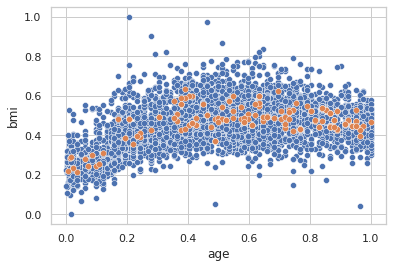

In [99]:
sns.scatterplot(data=X_train_imputation_copy[(~X_train_imputation_copy['bmi'].isnull()) & (X_train_imputation_copy['stroke'] == 0)], x="age", y="bmi")
sns.scatterplot(data=X_train_imputation.loc[X_train_imputation_copy[(X_train_imputation_copy['bmi'].isnull()) & (X_train_imputation_copy['stroke'] == 0)].index.tolist()], x="age", y="bmi")

Se representa en el conjunto de train, el BMI de aquellas personas que no tenían valores perdidos y que tenian stroke=1 contra los que tenían valores perdidos y stroke=1. Además, se representa teniendo en cuenta la variable age.

Se puede observar que los valores se parecen y se situan en la nube de puntos para las observaciones con stroke=1

<AxesSubplot:xlabel='age', ylabel='bmi'>

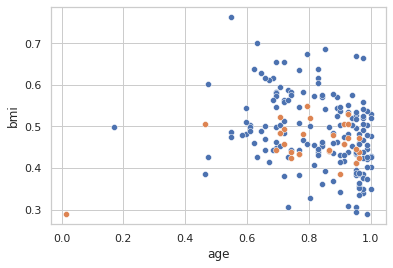

In [100]:
sns.scatterplot(data=X_train_imputation_copy[(~X_train_imputation_copy['bmi'].isnull()) & (X_train_imputation_copy['stroke'] == 1)], x="age", y="bmi")
sns.scatterplot(data=X_train_imputation.loc[X_train_imputation_copy[(X_train_imputation_copy['bmi'].isnull()) & (X_train_imputation_copy['stroke'] == 1)].index.tolist()], x="age", y="bmi")

## Preparación final del conjunto de datos

Se debe tener en cuenta que la variable **age** y **bmi** ya se encuentran escaladas entre valores 0 y 1, por lo tanto no se le aplicará dicha transformación nuevamente. A continuación formamos el conjunto de datos train y test finales, teniendo en cuenta lo mencionado y transformando las variables categóricas en dummies. 

In [101]:
X_train_final, X_test_final = X_train.copy(), X_test.copy()
print(X_train_final.shape, X_train.shape)
print(X_test_final.shape, X_test.shape)

(4087, 10) (4087, 10)
(1022, 10) (1022, 10)


Añadimos las variables **bmi** (ya escalada, sin outliers y valores perdidos) y la variable **age** (escalada) al train test final

In [102]:
X_train_final['age'], X_test_final['age'] = X_train_imputation['age'], X_test_imputation['age']
X_train_final['bmi'], X_test_final['bmi'] = X_train_imputation['bmi'], X_test_imputation['bmi']

Escalamos la variable avg_glucose_level con el **MinMaxScaler()**

In [103]:
min_max_scaler = MinMaxScaler()
X_train_final[['avg_glucose_level']] = min_max_scaler.fit_transform(X_train_final[['avg_glucose_level']])
X_test_final[['avg_glucose_level']] = min_max_scaler.transform(X_test_final[['avg_glucose_level']])
X_test_final.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
3797,Male,0.060059,0,0,No,children,Urban,0.652193,0.304916,Unknown
3903,Female,0.353027,0,0,Yes,Govt_job,Rural,0.521101,0.349678,never smoked
1033,Male,0.414062,0,0,No,Private,Urban,0.631573,0.490338,smokes
1173,Female,0.719238,0,0,Yes,Private,Rural,0.953338,0.642831,never smoked
3189,Female,0.633789,0,0,Yes,Private,Urban,0.620048,0.353711,never smoked


Aplicamos **LabelEncoder** para las variables: **gender**, **hypertension**, **heart_disease**, **ever_married** y **Residence_type**

In [105]:
categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
label_encoder = LabelEncoder()

for var in categorical_vars:
    X_train_final[var] = label_encoder.fit_transform(X_train_final[var])
    X_test_final[var] = label_encoder.transform(X_test_final[var])

Se convierten en dummies las variables **work_type** y **smoking_status**

In [106]:
X_train_final

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
3503,1,0.658203,1,0,1,Govt_job,0,0.578398,0.517302,formerly smoked
297,1,0.707031,1,0,1,Govt_job,0,0.042295,0.434111,smokes
2200,0,0.377441,0,0,1,Self-employed,1,0.927658,0.627152,smokes
1019,0,0.804688,0,0,1,Self-employed,1,0.780787,0.458434,never smoked
988,1,0.243164,0,0,0,Private,0,0.579848,0.450477,Unknown
...,...,...,...,...,...,...,...,...,...,...
4310,0,0.792480,0,0,1,Private,0,0.926401,0.630334,never smoked
2467,1,0.951172,0,0,1,Private,1,0.340193,0.466247,formerly smoked
4674,1,0.096680,0,0,0,children,0,0.170920,0.341499,Unknown
4499,1,0.731445,0,0,1,Self-employed,1,0.956574,0.611979,formerly smoked


In [107]:
print(X_train_final.shape, X_test_final.shape)
X_train_final = pd.get_dummies(X_train_final, columns=['work_type', 'smoking_status'], drop_first=True)
X_test_final = pd.get_dummies(X_test_final, columns=['work_type', 'smoking_status'], drop_first=True)
print(X_train_final.shape, X_test_final.shape)

(4087, 10) (1022, 10)
(4087, 14) (1022, 14)


Juntamos las columnas de la variable a predecir en los respectivos conjuntos de datos y guardamos los ficheros correspondientes

In [108]:
X_train_final['stroke'] = y_train
X_test_final['stroke'] = y_test

In [109]:
X_train_final.to_csv('train_final.csv', index=False)
X_test_final.to_csv('test_final.csv', index=False)